## Import

In [1]:
import os, sys, inspect, time

import numpy as np
import torch 
import matplotlib.pyplot as plt
torch.multiprocessing.set_sharing_strategy('file_system')

import discrepancy, visualization
from algorithms import ABC_algorithms, TPABC, SMCABC, SMC2ABC, SNLABC, SNL2ABC
import distributions 
import scipy.stats as stats

import utils_os, utils_math

%load_ext autoreload
%autoreload 2

## Problem Definition

In [2]:
from problems.ABC_problems import ABC_Problem

class Neuronal_Problem(ABC_Problem):
    
    def __init__(self, data, N=100, n=50):
        
        assert N <= data['Y'].shape[0]
        assert data['Y'].ndim == 2
        assert data['X'].shape[0] == data['Y'].shape[0]
        
        self.N = N # number of posterior samples
        self.n = n # length of the data vector x = {x_1, ..., x_n}
#         self.d = 5 # dims of sufficient statistics? d=2K? This argument is just not used anywhere... great
        self.prior_args = np.array([0,1]) # these are bounds on theta (on X in our case: [0,1])
        
        self.all_thetas = data['X']
        self.y_obs = data['Y']
        self.sim_accuracy = 4 # number of digits after a decimal point for theta
        self.sim = {np.round(data['X'][i],self.sim_accuracy): data['Y'][i] for i in range(data['X'].shape[0])} #here we use all!
        self.K = 1 # number of thetas
        self.stat = 'raw' # raw means that sufficient statistics is unknown (I guess). y_obs = data_obs
        
        self.data_obs = self.y_obs #important that first dim=N & y_dim = product of these dims
        
        self.is_batch_sampling_supported = False # (unfinished feature, so keep False for now) speed up rejection sampling
    
    def get_true_theta(self):
        pass # does not matter, as the result goes into 'statistics', where theta is currently not used

    def sample_from_prior(self, size=1):
        return np.random.choice(self.all_thetas,size=size,replace=True) # just 1 sample, but may be a vector!!!!
    
    def simulator(self, theta):
        # instead of using the best nearest neighbour, use the best from a subsample FIX LATER
        y = np.empty((len(theta),self.y_obs.shape[1]))
        for i,t_raw in enumerate(theta):
            t = np.round(t_raw,self.sim_accuracy)
            if t in self.sim:
                y[i] = self.sim[t]
            else: # this part is used for newly-generated samples; let's take the Y=Y(closest X).
                discr = np.abs(self.all_thetas - t) # get distances
                y[i] = self.sim[np.round(self.all_thetas[np.argmin(discr)],self.sim_accuracy)] # take the closest
        return y # self.n x thetas (which is 1 o_O )

    # B. correlation between latent
    def _ss_corr(self, Z):
        V = np.mat(Z).T * np.mat(Z) / Z.shape[0]
        (d,d) = V.shape
        upper_tri_elements = V[np.triu_indices(d, k=1)]
        stat = np.array(upper_tri_elements)
        return stat
    
    def statistics(self, data, theta=None):
        if self.stat == 'raw':
            # (correlation) as summary statistics (NO MARGINALS in these data)
            stat = self._ss_corr(data)
            return stat
        else:
            raise NotImplementedError('No ground truth statistics')

In [34]:
import pickle as pkl
with open(f'/home/nina/CopulaGP/plos_fig5_data/ST260_Day1_Dataset.pkl',"rb") as f:
    data = pkl.load(f)
    
data['Y'] = data['Y'][:,:10] # taking the first N variables here (use second index)
print(data['Y'].shape) # samples x neuronal/behavioral variables
    
problem = Neuronal_Problem(data)

DIR = 'results/Neuronal' 

(21471, 10)


In [37]:
### Sequential Neural Likelihood + 
hyperparams = ABC_algorithms.Hyperparams()
hyperparams.save_dir = DIR
hyperparams.device = 'cuda:0'
hyperparams.num_sim = 1000                        # number of simulations
hyperparams.L = 5                                # number of learning rounds
hyperparams.hidden_ratio = 0.1                   # dimensionality of S(x)
hyperparams.type = 'plain'                       # the network architecture of S(x), use CNN here
hyperparams.estimator = 'NWJ'                    # MI estimator; JSD or DC, see the paper
hyperparams.nde = 'MDN'                          # nde; MAF (D>1) or MDN (D=1)

snl2_abc = SNL2ABC.SNL2_ABC(problem, discrepancy=discrepancy.eculidean_dist, hyperparams=hyperparams)


In [ ]:
snl2_abc.run()


iteration  0
# of cpus =  4
[ABC] sub-process start!
[sampling] finished sampling  10
[sampling] finished sampling  20
[sampling] finished sampling  30
[sampling] finished sampling  40
[ABC] sub-process start!
[ABC] sub-process start!
[ABC] sub-process start!

 > fitting encoder
summary statistic dim = 4 original dim = 45
architecture [45, 100, 100, 4]
validation size= 0.8
finished: t= 0 loss= 0.2979995906352997 loss val= 0.29321515560150146 time= 0.11103296279907227
finished: t= 50 loss= 0.08466088771820068 loss val= 0.07968932390213013 time= 0.08026671409606934
finished: t= 100 loss= 0.008992254734039307 loss val= 0.008963286876678467 time= 0.09358429908752441
finished: t= 150 loss= 0.003239750862121582 loss val= 0.0031341910362243652 time= 0.10678577423095703
finished: t= 200 loss= 0.0008211731910705566 loss val= 0.0007680058479309082 time= 0.12104392051696777
finished: t= 250 loss= 0.00013583898544311523 loss val= 0.00014454126358032227 time= 0.11028313636779785
finished: t= 300 lo

In [16]:
# theta = snl2_abc.problem.sample_from_prior(size=20000)
# net = snl2_abc.nde_net
# y_obs, theta = snl2_abc.convert_stat(snl2_abc.whiten(snl2_abc.y_obs)), theta
# # y_obs = np.repeat(y_obs,400,axis=0)
# print(y_obs.shape)
# y_obs, theta = torch.tensor(y_obs).float(), torch.tensor(theta).float().view(1, -1)
# log_probs = net.log_probs(inputs=y_obs, cond_inputs=theta)

(array([  3.,  16.,  50., 132., 217., 225., 210., 100.,  37.,  10.]),
 array([0.12671691, 0.23752056, 0.3483242 , 0.45912785, 0.5699315 ,
        0.68073514, 0.79153879, 0.90234243, 1.01314608, 1.12394972,
        1.23475337]),
 <a list of 10 Patch objects>)

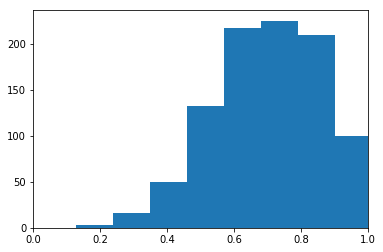

In [21]:
# let us check that the prior did not collapse 
theta = np.empty(1000)
for i in range(len(theta)): 
    theta[i] = snl2_abc.prior()
plt.xlim([0,1])
plt.hist(theta)

In [22]:
# get latents s(x)
snl2_abc.convert_stat(snl2_abc.problem.statistics(data['Y']))

array([[-0.04942602, -0.03361893,  0.00481226]], dtype=float32)

In [25]:
# calculate MI using all generated subsamples
all_stats = torch.tensor(np.vstack(snl2_abc.all_stats[0:snl2_abc.l+1])).float()
all_samples = torch.tensor(np.vstack(snl2_abc.all_samples[0:snl2_abc.l+1])).float()
print(all_samples.shape)
snl2_abc.vae_net.MI(all_stats,all_samples,n=100)

torch.Size([200, 1])


tensor(0.9385, grad_fn=<DivBackward0>)

In [27]:
# calculate MI using all recordings
stats = torch.tensor(snl2_abc.problem.statistics(data['Y'])).float()
samples = torch.tensor(data['X']).float()
print(all_samples.shape)
snl2_abc.vae_net.MI(all_stats,all_samples,n=100)

torch.Size([200, 1])


tensor(0.9385, grad_fn=<DivBackward0>)